In [1]:
import glob
from datetime import datetime

import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.stats.api as sms
import tikzplotlib as tpl
import xgboost as xgb
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    PrecisionRecallDisplay,
    RocCurveDisplay,
    auc,
    mean_squared_error,
    precision_recall_curve,
    r2_score,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from zedstat import zedstat

from truthnet import truthnet

In [8]:
len(glob.glob("data/classification/lgbm_auc_res/auc_df_lgb*.csv"))

24

In [9]:
lgbm = pd.concat([pd.read_csv(df) for df in glob.glob("data/classification/lgbm_auc_res/auc_df_lgb*.csv")])

In [10]:
lgbm

,questions asked,auc,z_auc,z_auc_lb,z_auc_ub
0,1,0.590909,0.590909,0.590909,0.590909
1,6,0.613889,0.643056,0.561552,0.724664
2,11,0.735294,0.771000,0.706181,0.835864
3,16,0.769585,0.795714,0.739375,0.852109
4,21,0.810150,0.833632,0.780535,0.886750
...,...,...,...,...,...
38,191,1.000000,0.500000,0.417720,0.582588
39,196,1.000000,0.500000,0.417720,0.582588
40,201,1.000000,0.500000,0.417720,0.582588
41,206,1.000000,0.500000,0.417720,0.582588


In [11]:
conf = 0.95

lgbm_auc_ci_var = lgbm.groupby(["questions asked"], as_index=False).agg(
    mean=pd.NamedAgg(column="auc", aggfunc="mean"),
    var=pd.NamedAgg(column="auc", aggfunc="var"),
    ci=pd.NamedAgg(
        column="auc",
        aggfunc=lambda x: sms.DescrStatsW(x).tconfint_mean(alpha=1 - conf),
    ),
)

In [12]:
lgbm_auc_ci_var.assign(
    lower=lambda x: [c[0] for c in x["ci"]], upper=lambda x: [c[1] for c in x["ci"]]
).drop("ci", axis="columns").to_csv("lgbm_auc_ci_var.csv", index=False)

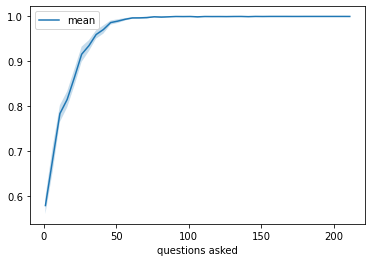

In [13]:
fig, ax = plt.subplots()
lgbm_auc_ci_var.plot(x="questions asked", y="mean", ax=ax)
ax.fill_between(
    lgbm_auc_ci_var["questions asked"],
    [x[0] for x in lgbm_auc_ci_var["ci"]],
    [x[1] for x in lgbm_auc_ci_var["ci"]],
    alpha=0.25,
)

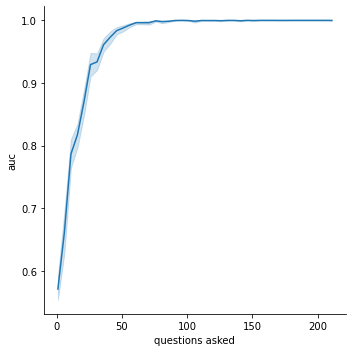

In [3]:
g = sns.relplot(
    data=lgb,
    x="questions asked",
    y="auc",
    kind="line",
)

In [4]:
def _sns_plot_to_df(ax, line_idx=0):
    # get mean
    mean_p_df = pd.DataFrame(
        data={0: ax.lines[line_idx].get_xdata(), 1: ax.lines[0].get_ydata()}
    )

    # get upper/lower conf. bounds
    p = ax.collections[0].get_paths()
    p_df = pd.DataFrame(p[0].vertices).sort_values(by=[0, 1]).drop_duplicates()
    constant_bounds = p_df[~p_df[0].duplicated(keep=False)]
    p_df = pd.concat([p_df, constant_bounds]).sort_values(by=0)
    p_df["lim"] = [
        x
        for y in zip(np.tile("lower", len(mean_p_df)), np.tile("upper", len(mean_p_df)))
        for x in y
    ]

    # merge
    p_df_p = p_df.pivot(index=0, columns="lim").reset_index()
    p_df_p.columns = p_df_p.columns.to_flat_index()
    p_df_p = p_df_p.set_axis(["x", "ci_lower", "ci_upper"], axis="columns")
    df = pd.merge(p_df_p, mean_p_df, how="inner", left_on="x", right_on=0)

    df = df.rename(columns={1: "mean"}).drop(0, axis="columns")
    return df[["x", "mean", "ci_lower", "ci_upper"]]

In [5]:
lgb_auc_ci = _sns_plot_to_df(g.figure.gca())
lgb_auc_ci

,x,mean,ci_lower,ci_upper
0,1.0,0.570866,0.553581,0.590963
1,6.0,0.661853,0.628581,0.694771
2,11.0,0.786532,0.765007,0.810287
3,16.0,0.817412,0.796863,0.834797
4,21.0,0.869966,0.848196,0.889455
5,26.0,0.929379,0.948031,0.910381
6,31.0,0.933639,0.920652,0.947185
7,36.0,0.961168,0.950005,0.971395
8,41.0,0.972949,0.962472,0.982189
9,46.0,0.983531,0.977562,0.989266


In [37]:
lgb_auc_ci.to_csv("lgb_auc_ci.csv", index=False)

In [25]:
print(tpl.get_tikz_code(fig, standalone=False))

% This file was created with tikzplotlib v0.10.1.
\begin{tikzpicture}

\definecolor{darkgray176}{RGB}{176,176,176}
\definecolor{lightgray204}{RGB}{204,204,204}
\definecolor{steelblue31119180}{RGB}{31,119,180}

\begin{axis}[
legend cell align={left},
legend style={
  fill opacity=0.8,
  draw opacity=1,
  text opacity=1,
  at={(0.03,0.97)},
  anchor=north west,
  draw=lightgray204
},
tick align=outside,
tick pos=left,
x grid style={darkgray176},
xlabel={questions asked},
xmin=-9.5, xmax=221.5,
xtick style={color=black},
y grid style={darkgray176},
ymin=0.5266763630605, ymax=1.02346106653809,
ytick style={color=black}
]
\path [fill=steelblue31119180, fill opacity=0.25]
(axis cs:1,0.59247494604339)
--(axis cs:1,0.549257485945845)
--(axis cs:6,0.625314339370823)
--(axis cs:11,0.760884978286131)
--(axis cs:16,0.794851985393529)
--(axis cs:21,0.846968477998267)
--(axis cs:26,0.90770791156786)
--(axis cs:31,0.91858248803595)
--(axis cs:36,0.948991160867885)
--(axis cs:41,0.961620232893018)
--(

In [39]:
df = lgb_auc_ci

In [76]:
x = pd.Series([x for x in np.arange(1, 212, 0.5) if x not in df["x"].values], name="x")

In [78]:
x

0        1.5
1        2.0
2        2.5
3        3.0
4        3.5
       ...  
374    209.0
375    209.5
376    210.0
377    210.5
378    211.5
Name: x, Length: 379, dtype: float64

In [121]:
pd.concat([df, pd.DataFrame(x)]).sort_values(by="x").reset_index(drop=True)

,x,mean,ci_lower,ci_upper
0,1.0,0.553178,0.530816,0.57898
1,1.5,NaN,NaN,NaN
2,2.0,NaN,NaN,NaN
3,2.5,NaN,NaN,NaN
4,3.0,NaN,NaN,NaN
...,...,...,...,...
417,209.5,NaN,NaN,NaN
418,210.0,NaN,NaN,NaN
419,210.5,NaN,NaN,NaN
420,211.0,1.000000,1.000000,1.00000


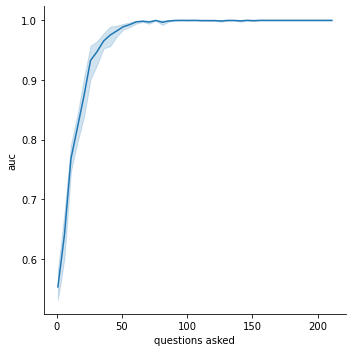

In [130]:
g.figure

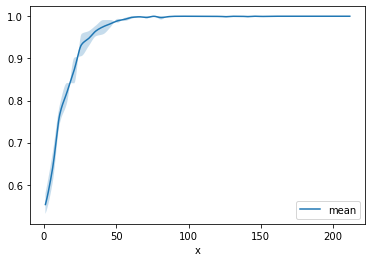

In [137]:
ddf = (
    pd.concat([df, pd.DataFrame(x)])
    .sort_values(by="x")
    .reset_index(drop=True)
    .interpolate(method="pchip")
)

ax = ddf.plot(x="x", y="mean")
ax.fill_between(ddf["x"], ddf["ci_lower"], ddf["ci_upper"], alpha=0.25)

In [125]:
ddf.head(20)

,x,mean,ci_lower,ci_upper
0,1.0,0.553178,0.530816,0.578980
1,1.5,0.555084,0.527392,0.584959
2,2.0,0.558954,0.527088,0.591962
3,2.5,0.564614,0.529632,0.599899
4,3.0,0.571892,0.534753,0.608680
5,3.5,0.580617,0.542180,0.618214
6,4.0,0.590617,0.551641,0.628410
7,4.5,0.601719,0.562865,0.639179
8,5.0,0.613751,0.575581,0.650429
9,5.5,0.626541,0.589517,0.662070


In [109]:
from scipy.interpolate import BSpline, interp1d, make_interp_spline


def _get_spline_dat(df, x, var):
    cubic = make_interp_spline(df[x], df[var], k=1)
    res = cubic(np.linspace(df[x].min(), df[x].max(), num=50, endpoint=True))

    return res


def _get_all_splines(dat, x):
    df = pd.DataFrame(dat).reset_index()
    resdf = pd.DataFrame(
        [_get_spline_dat(df, x, var) for var in df.columns]
    ).transpose()
    resdf.columns = df.columns

    return pd.melt(resdf, id_vars=x)

In [110]:
_get_all_splines(df, "x")

,x,variable,value
0,1.000000,index,0.000000
1,5.285714,index,0.857143
2,9.571429,index,1.714286
3,13.857143,index,2.571429
4,18.142857,index,3.428571
...,...,...,...
195,193.857143,ci_upper,1.000000
196,198.142857,ci_upper,1.000000
197,202.428571,ci_upper,1.000000
198,206.714286,ci_upper,1.000000


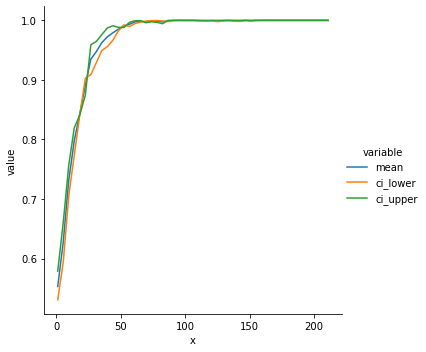

In [112]:
sns.relplot(
    data=_get_all_splines(df, "x").query("variable!='index'"),
    x="x",
    y="value",
    hue="variable",
    kind="line",
)

In [104]:
lgb

,questions asked,auc,z_auc,z_auc_lb,z_auc_ub
0,1,0.590909,0.590909,0.590909,0.590909
1,6,0.613889,0.643056,0.561552,0.724664
2,11,0.735294,0.771000,0.706181,0.835864
3,16,0.769585,0.795714,0.739375,0.852109
4,21,0.810150,0.833632,0.780535,0.886750
...,...,...,...,...,...
38,191,1.000000,0.500000,0.417720,0.582588
39,196,1.000000,0.500000,0.417720,0.582588
40,201,1.000000,0.500000,0.417720,0.582588
41,206,1.000000,0.500000,0.417720,0.582588
